# VAE attempt 3
Based off of Alexander Van de Kleut's work. See [this post](https://avandekleut.github.io/vae/) for some theory and explination.

In [1]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/' 
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'

class ArtKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        kymos = torch.from_numpy(kymos)
        # self.x = kymos[:,None,:,:]
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))
        kymos = kymos.astype('float32')
        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

### Autoencoder architecture, notice this is **NOT** a VAE

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(1200, 512) # input flattened kymograph
        self.linear2 = nn.Linear(512, latent_dims) # squishes into latent space
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 0) #may have to change start dim if not along right axis, I guessed randomly
        x = F.relu(self.linear2(F.relu(self.linear1(x))))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 20, 60))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### Pretty good training loop, can probably repurpose for VAE as well

In [5]:
def train(autoencoder, lr, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        startTime = time.perf_counter()
        overall_loss = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            overall_loss += loss.item()
            opt.step()
        timediff = (time.perf_counter()-startTime)
        print("\tEpoch {} complete \tTotal Loss: {} \tTraining time: {} ".format(epoch+1, loss, timediff))
    return autoencoder

In [6]:
# dataset = ArtKymoDataset()
# latent_dims = 10
# learning_rate = 1e-5 #his seems to be sweet spot, can try experimenting more though
# autoencoder = Autoencoder(latent_dims).to(device)
# autoencoder = train(autoencoder, lr=learning_rate, data=dataset, epochs=10)

### Variational Autoencoder

In [7]:
class Kymo_VE(nn.Module):
    def __init__(self, latent_dims):
        super(Kymo_VE, self).__init__()
        self.linearInput = nn.Linear(1200,512)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256,256)
        self.linearMu = nn.Linear(256, latent_dims)
        self.linearSigma = nn.Linear(256, latent_dims)

        self.Normal = torch.distributions.Normal(0,1)
        self.KLDivergence = 0 #Kullback–Leibler divergence

    def forward(self, x):
        x = torch.flatten(x, start_dim=0) #again, might have to change later, not sure if this should be 0 or 1
        x = F.relu(self.linearInput(x))
        x = F.relu(self.linear2(F.relu(self.linear1(x))))
        mu = self.linearMu(x)
        sigma = torch.exp(self.linearSigma(x))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.KLDivergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

class VE_Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(VE_Decoder, self).__init__()
        self.linearLatent = nn.Linear(latent_dims, 256)
        self.linear1 = nn.Linear(256,256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linearLatent(z))
        z = F.relu(self.linear2(F.relu(self.linear1(z))))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 20, 60))

class Kymo_VAE(nn.Module):
    def __init__(self, latent_dims):
        super(Kymo_VAE, self).__init__()
        self.encoder = Kymo_VE(latent_dims)
        self.decoder = VE_Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


## Convolutional VAE V1.0

Suddenly, Conv2d is working, but I really think it shouldn't be...

In [8]:
class Convo_Kymo_VE(nn.Module):
    def __init__(self, latent_dims):
        super(Convo_Kymo_VE, self).__init__()
        self.linearInput = nn.Linear(1200,512)
        self.linear1 = nn.Linear(512, 256)
        self.convo = nn.Conv2d(256,256,3)
        self.linear2 = nn.Linear(256,256)
        self.linearMu = nn.Linear(256, latent_dims)
        self.linearSigma = nn.Linear(256, latent_dims)

        self.Normal = torch.distributions.Normal(0,1)
        self.KLDivergence = 0 #Kullback–Leibler divergence

    def forward(self, x):
        x = torch.flatten(x, start_dim=0) #again, might have to change later, not sure if this should be 0 or 1
        x = F.relu(self.linearInput(x))
        x = F.relu(self.linear1(x))
        for _ in range(10):
            z = F.tanh(self.convo(z))
        x = F.relu(self.linear2(x))
        mu = self.linearMu(x)
        sigma = torch.exp(self.linearSigma(x))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.KLDivergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

class Convo_VE_Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Convo_VE_Decoder, self).__init__()
        self.linearLatent = nn.Linear(latent_dims, 256)
        self.linear1 = nn.Linear(256,256)
        self.convo = nn.Conv2d(256,256,3)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linearLatent(z))
        for _ in range(10):
            z = F.tanh(self.convo(z))
        z = F.relu(self.linear2(F.relu(self.linear1(z))))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 20, 60))

class Convo_Kymo_VAE(nn.Module):
    def __init__(self, latent_dims):
        super(Convo_Kymo_VAE, self).__init__()
        self.encoder = Kymo_VE(latent_dims)
        self.decoder = VE_Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


#### VAE Training Loop

In [9]:
def trainVAE(autoencoder, lr, data, epochs=10, tol = 1000):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    data_len = len(data)
    past_loss = 0
    for epoch in range(epochs):
        startTime = time.perf_counter()
        loss_count = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.KLDivergence
            loss.backward()
            loss_count += loss.item()
            opt.step()
        timediff = (time.perf_counter()-startTime)
        print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
        if abs(past_loss-loss_count) < tol:
            print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
            return autoencoder
        past_loss = loss_count
    return autoencoder

In [40]:
# run the training loop
dataset = ArtKymoDataset()
learning_rate = 1e-6
VAE = Convo_Kymo_VAE(latent_dims=4).to(device)
VAE = trainVAE(VAE, lr=learning_rate, data=dataset, epochs=100)

	Epoch 1 complete 	Average Loss: 182464.426 	Training time: 3.926 
	Epoch 2 complete 	Average Loss: 182370.298 	Training time: 3.703 
	Epoch 3 complete 	Average Loss: 181965.609 	Training time: 3.814 
	Epoch 4 complete 	Average Loss: 180842.576 	Training time: 3.991 
	Epoch 5 complete 	Average Loss: 178849.097 	Training time: 4.722 
	Epoch 6 complete 	Average Loss: 176627.106 	Training time: 6.262 
	Epoch 7 complete 	Average Loss: 174963.164 	Training time: 6.776 
	Epoch 8 complete 	Average Loss: 173894.277 	Training time: 6.742 
	Epoch 9 complete 	Average Loss: 173174.797 	Training time: 6.791 
	Epoch 10 complete 	Average Loss: 172640.679 	Training time: 6.921 
	Epoch 11 complete 	Average Loss: 172226.192 	Training time: 7.754 
	Epoch 12 complete 	Average Loss: 171893.197 	Training time: 8.267 
	Epoch 13 complete 	Average Loss: 171634.165 	Training time: 10.205 
	Epoch 14 complete 	Average Loss: 171418.332 	Training time: 10.995 
	Epoch 15 complete 	Average Loss: 171228.270 	Training 

In [41]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            plt.scatter(z[dims[0]], z[dims[1]], c='b', label = ('pol' if i == 101 else None))
        else:
            plt.scatter(z[dims[0]], z[dims[1]], c='g', label = ('rand' if i == 201 else None))

    if exp_data != None:
        for i, x in enumerate(exp_data):
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None))

    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.legend()
    plt.title('Kymograph position in Latent Space')
    plt.legend

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(3):
        idz = np.random.randint(0,len(data))
        y = data[idz]
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(y[0,:,:], cmap='gray')
        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

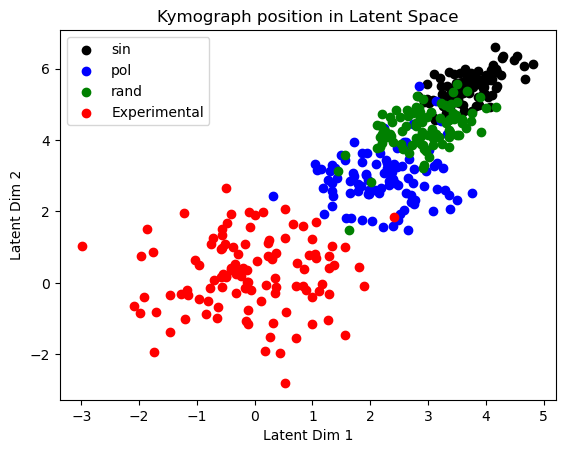

In [49]:
exp_dataset = ExpKymoDataset()
plot_latent(VAE, dataset, dims=[1,3], exp_data=exp_dataset)

We can see that the VAE is not doing a very good job at producing meaningful recondstructions however...
This is potentially because it is compressing into 2D at latent space, giving it control over total and relative brightness, hence why all the reconstructed kymos look like scaled copies of one another despite separation in the latent space.

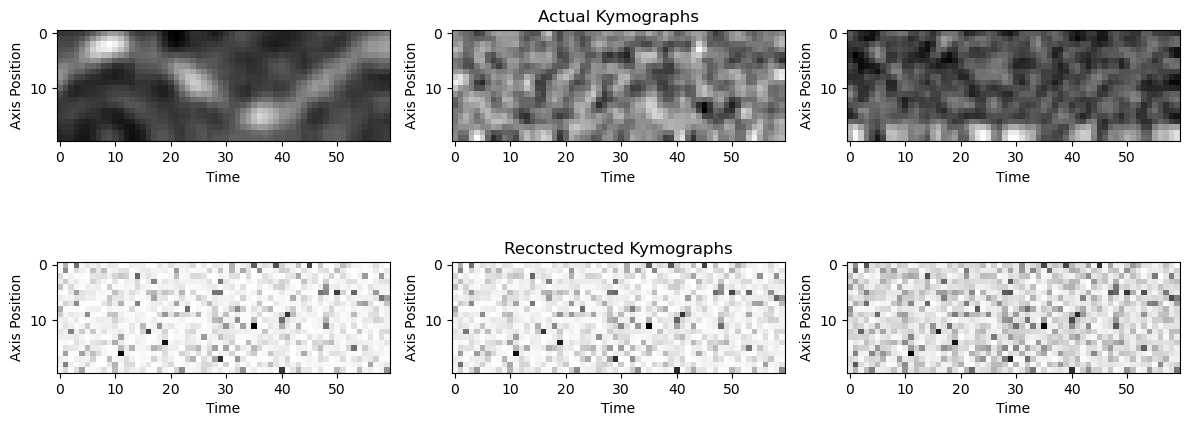

In [48]:
# Sample reconstructed kymographs
plot_sample_im(VAE, dataset)